<a href="https://colab.research.google.com/github/meduardajustino/Uma-An-lise-com-Dados-da-POF-2017-2018/blob/main/Script_R_Regional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages(c(
  "tidyverse",    # dplyr, ggplot2, etc
  "readr",        # para importar CSV
  "broom",        # para extrair coeficientes do modelo
  "srvyr",        # se quiser aplicar pesos corretamente
  "modelsummary",  # para exibir tabelas de regressão
  "readxl"       # para importar arquivos Excel
))

library(tidyverse)
library(broom)
library(modelsummary)
library(readxl) # Carregar o pacote readxl

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Rows: 169
Columns: 9
$ cod         <dbl> 2201003, 2103032, 2201005, 2103039, 2104009, 2101012, 2104…
$ uf          <dbl> 50, 31, 33, 29, 50, 23, 29, 35, 52, 35, 35, 26, 43, 26, 31…
$ precom      <dbl> 2.7707598, 15.2152463, 96.2000000, 0.5845900, 6.9443061, 6…
$ subitem     <chr> "CarvÃ£o vegetal", "Revestimento de piso e parede", "GÃ¡s …
$ cod_subitem <dbl> 2201003, 2103032, 2201005, 2103039, 2104009, 2101012, 2104…
$ grupo       <chr> "habitacao", "habitacao", "habitacao", "habitacao", "habit…
$ partic      <dbl> 0.00, 0.11, 0.43, 0.07, 0.35, 0.00, 0.24, 4.55, 2.36, 3.78…
$ rm          <dbl> 5, 3, 3, 2, 5, 2, 2, 3, 5, 3, 3, 2, 4, 2, 3, 1, 4, 3, 2, 2…
$ peso        <dbl> 0.000000000, 0.001177730, 0.004863704, 0.000742745, 0.0037…


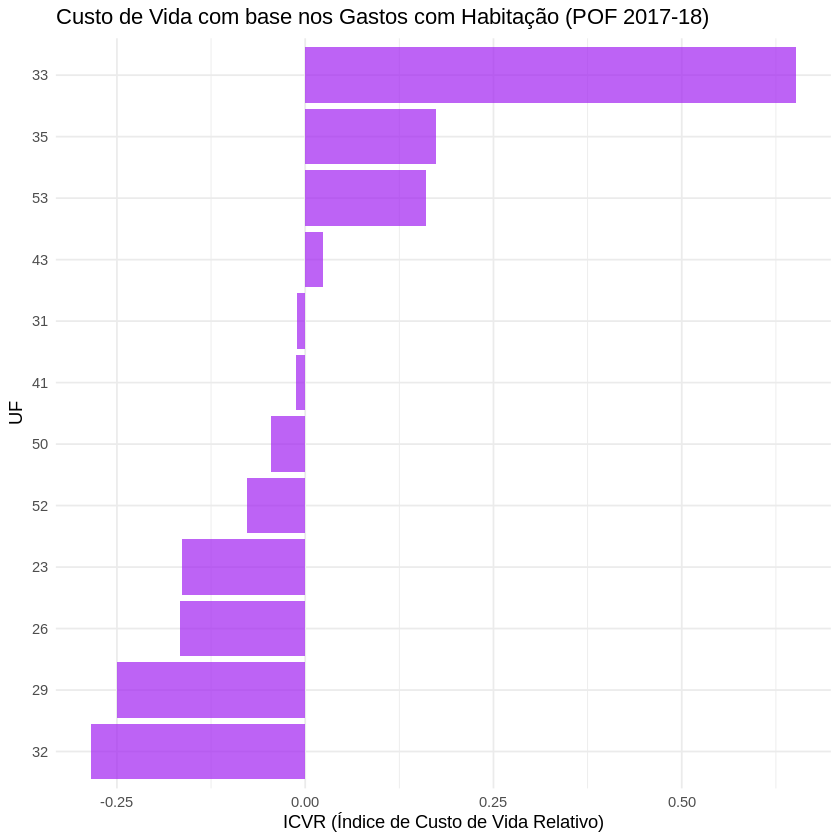

In [ ]:

# Definir diretório e importar os dados
df <- read_excel("/content/ipc_gastos pof 2017-2018 aula.xlsx")
# Filtrar apenas o grupo "Habitação"
df <- df %>%
  filter(str_to_lower(grupo) == "habitacao")

glimpse(df)

# Criar log do preço
df <- df %>%
  mutate(lnp = log(precom))

# Criar dummies para grupos (produto) e estados (UF)
df <- df %>%
  mutate(across(c(cod, uf), as.factor)) %>%
  mutate(across(c(cod, uf), ~ factor(.))) %>%
  mutate(peso = as.numeric(peso))

# Rodar regressão CPD (Country-Product Dummy)
modelo <- lm(lnp ~ cod + uf, data = df, weights = peso)

# Ver coeficientes por UF
coefs <- tidy(modelo) %>%
  filter(str_detect(term, "uf")) %>%
  mutate(uf = str_remove(term, "uf")) %>%
  mutate(uf = as.numeric(uf)) %>%
  rename(coef = estimate) %>%
  mutate(ecoef = exp(coef)) %>%
  mutate(m_ecoef = mean(ecoef),
         icvr = (ecoef / m_ecoef) - 1)

# Reduzir para tabela final por UF
tabela_icvr <- coefs %>%
  select(uf, icvr) %>%
  arrange(desc(icvr))

# Visualização opcional
ggplot(tabela_icvr, aes(x = reorder(as.factor(uf), icvr), y = icvr)) +
  geom_col(fill = "purple", alpha = 0.7) +
  coord_flip() +
  labs(x = "UF", y = "ICVR (Índice de Custo de Vida Relativo)",
       title = "Custo de Vida com base nos Gastos com Habitação (POF 2017-18)") +
  theme_minimal()


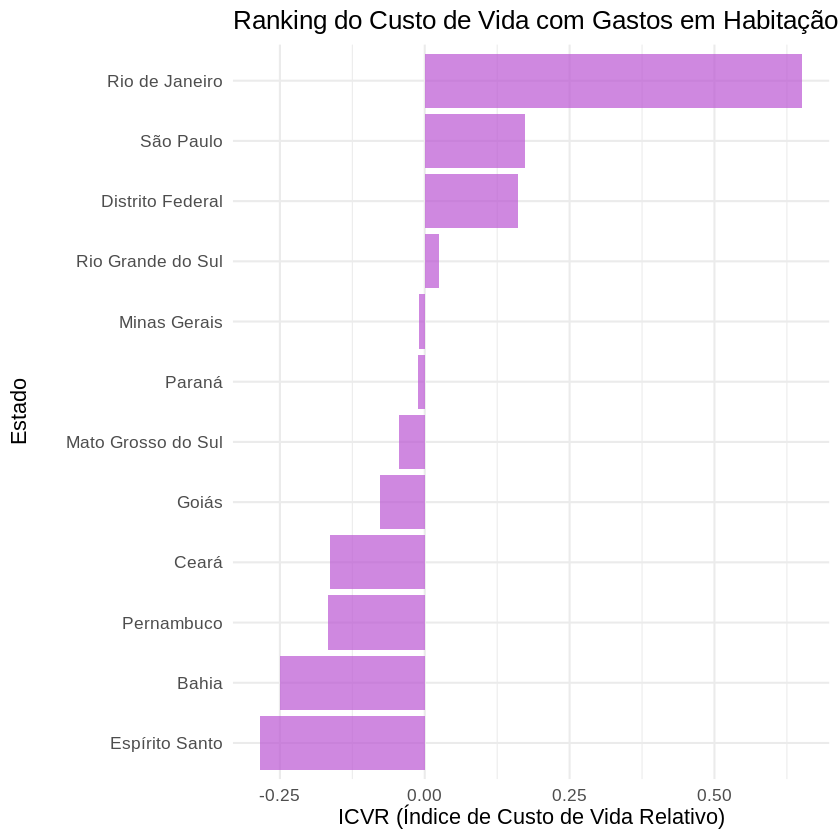

In [ ]:
# Visualizações para facilitar a escrita do trabalho

# correspondência UF x Estado
ufs_nomes <- tibble(
  uf = c(11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 35, 41, 42, 43, 50, 51, 52, 53),
  estado = c("Rondônia", "Acre", "Amazonas", "Roraima", "Pará", "Amapá", "Tocantins",
             "Maranhão", "Piauí", "Ceará", "Rio Grande do Norte", "Paraíba", "Pernambuco",
             "Alagoas", "Sergipe", "Bahia", "Minas Gerais", "Espírito Santo", "Rio de Janeiro",
             "São Paulo", "Paraná", "Santa Catarina", "Rio Grande do Sul", "Mato Grosso do Sul",
             "Mato Grosso", "Goiás", "Distrito Federal")
)

# juntar com a tabela_icvr
tabela_icvr_nomeada <- tabela_icvr %>%
  left_join(ufs_nomes, by = "uf") %>%
  arrange(desc(icvr))

library(ggplot2)

# Atribuir o gráfico a um objeto
plot_icvr_estados <- ggplot(tabela_icvr_nomeada, aes(x = reorder(estado, icvr), y = icvr)) +
  geom_col(fill = "mediumorchid", alpha = 0.7) +
  coord_flip() +
  labs(
    x = "Estado",
    y = "ICVR (Índice de Custo de Vida Relativo)",
    title = "Ranking do Custo de Vida com Gastos em Habitação (POF 2017-18)"
  ) +
  theme_minimal(base_size = 13)

# Exibir o gráfico
print(plot_icvr_estados)

# salvar CSV final
write_csv(tabela_icvr_nomeada, "icvr_habitacao_por_estado.csv")

# Salvar o gráfico com dimensões específicas
ggsave("ranking_icvr_habitacao.png", plot = plot_icvr_estados, width = 10, height = 8, units = "in") # Exemplo: 10 polegadas de largura por 8 de altura

In [ ]:


#Nova forma de visualização - mapa do Brasil

install.packages(c("geobr", "sf", "ggplot2", "dplyr", "readr"))  # caso não tenha
library(geobr)
library(sf)
library(ggplot2)
library(dplyr)
library(readr)

# Extração dos coeficientes
tabela_icvr <- tidy(modelo) %>%
  filter(str_detect(term, "uf")) %>%
  mutate(
    uf = str_remove(term, "uf"),
    uf = as.integer(uf),
    coef = estimate,
    ecoef = exp(coef)
  ) %>%
  mutate(
    m_ecoef = mean(ecoef),
    icvr = (ecoef / m_ecoef) - 1
  ) %>%
  select(uf, icvr) %>%
  arrange(desc(icvr))

# Obter mapa
mapa_uf <- read_state(year = 2020)

# Juntar mapa com dados
mapa_icvr_dados <- mapa_uf %>%
  left_join(tabela_icvr, by = c("code_state" = "uf"))

# Visualizar para checar
summary(mapa_icvr_dados$icvr)  # Não deve ser tudo NA

# Mapa
ggplot(mapa_icvr_dados) +
  geom_sf(aes(fill = icvr), color = "white") +
  scale_fill_gradient2(
    low = "red", mid = "white", high = "blue",
    midpoint = 0, name = "ICVR"
  ) +
  labs(
    title = "Custo de Vida Relativo com Gastos em Habitação (POF 2017-18)",
    subtitle = "Índice de Custo de Vida Relativo por UF",
    caption = "Fonte: POF 2017-18, IBGE"
  ) +
  theme_minimal(base_size = 13)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘s2’


